## PREDICTING HUMAN ACTIVITIES FROM SMART DEVICES (SMARTPHONES and SMARTWATCHES)

<font color='blue'>Student name: Thi Dinh</font>

In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

from scipy.spatial import distance
from scipy.stats import pearsonr

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from keras.models import Model
from keras.layers import Conv1D, Dense, Flatten, Input, MaxPooling1D, Dropout, BatchNormalization, TimeDistributed, LSTM, Dropout
from keras.layers.merge import concatenate
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

np.random.seed(42)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
C:\Users\kimho\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kimho\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kimho\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kimho\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

### I. INSPECT DATA

In [2]:
#function to create dataframe from file .txt
def create_df(path, prefix=''):
    df = pd.read_csv(path, header=None, \
                    names = ['subject_id','activity_code','timestamp','x','y','z'])
    df['z'] = [ i[:-1] for i in df['z']]   #slice the "," in z value
    df['z'] = df['z'].astype(float)
    df['number'] = df.groupby(['activity_code']).cumcount()+1    #add order of each activity
    df['activity_number'] = df['activity_code'] + '_' + df['number'].astype(str) #combine activity_code with number so I will have unique key value for merging by the order of activity
    df = df.add_prefix(prefix) #add prefix to separate with other dataframes
    return df

In [3]:
#get number of rows in each sensor and check null values and duplicated values
rows = {'subject_id':[], 'phone_accel_rows':[], 'phone_gyro_rows':[], 'watch_accel_rows':[], 'watch_gyro_rows':[],'has_null':[], 'has_duplicated':[]}
for i in list(range(1600, 1651)):
    phone_accel = create_df(f'raw/phone/accel/data_{i}_accel_phone.txt', prefix='phone_accel_')  
    phone_gyro = create_df(f'raw/phone/gyro/data_{i}_gyro_phone.txt', prefix='phone_gyro_')  
    watch_accel = create_df(f'raw/watch/accel/data_{i}_accel_watch.txt', prefix='watch_accel_')
    watch_gyro = create_df(f'raw/watch/gyro/data_{i}_gyro_watch.txt', prefix='watch_gyro_')
    rows['subject_id'].append(i)
    rows['phone_accel_rows'].append(phone_accel.shape[0])
    rows['phone_gyro_rows'].append(phone_gyro.shape[0])
    rows['watch_accel_rows'].append(watch_accel.shape[0])
    rows['watch_gyro_rows'].append(watch_gyro.shape[0])
    
    #check missing value
    if phone_accel.isnull().sum().sum() > 0 or phone_gyro.isnull().sum().sum() > 0 \
           or watch_accel.isnull().sum().sum() > 0 or watch_gyro.isnull().sum().sum() > 0:
        rows['has_null'].append(1)
    else: rows['has_null'].append(0)
        
    #check duplicated value
    if phone_accel.duplicated().sum() > 0 or phone_gyro.duplicated().sum() > 0 \
           or watch_accel.duplicated().sum() > 0 or watch_gyro.duplicated().sum() > 0:
        rows['has_duplicated'].append(1)
    else: rows['has_duplicated'].append(0)    
        

In [4]:
df_rows = pd.DataFrame(rows)
#get total number of rows in each sensor
display(df_rows.drop('subject_id', axis=1).sum(axis='rows'))

phone_accel_rows    4804403
phone_gyro_rows     3608635
watch_accel_rows    3777046
watch_gyro_rows     3440342
has_null                  0
has_duplicated            0
dtype: int64

<font color='blue'>There is no missing value and duplicated value. <br>And the number of measurement in each sensor is different even all activities performed in same time length - 3 minutes each and there are so many sensor readings for the phone accelerometer.</font>

In [5]:
#list of activities
activities = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'O', 'P', 'Q', 'R', 'S']

In [6]:
#generate number of measurements/rows of each activity in each sensor
rows_in_activities = {'activity':[], 'phone_accel':[],'phone_gyro':[],'watch_accel':[], 'watch_gyro':[]}
for i in list(range(1600, 1651)):
    phone_accel = create_df(f'raw/phone/accel/data_{i}_accel_phone.txt', prefix='phone_accel_')  
    phone_gyro = create_df(f'raw/phone/gyro/data_{i}_gyro_phone.txt', prefix='phone_gyro_')  
    watch_accel = create_df(f'raw/watch/accel/data_{i}_accel_watch.txt', prefix='watch_accel_')
    watch_gyro = create_df(f'raw/watch/gyro/data_{i}_gyro_watch.txt', prefix='watch_gyro_')
    
    for act in activities:
        rows_in_activities['activity'].append(act)
        
        phone_accel_rows = []
        phone_gyro_rows = []
        watch_accel_rows = []
        watch_gyro_rows = []
        
        phone_accel_rows.append(phone_accel[phone_accel['phone_accel_activity_code'] == act].shape[0])
        phone_gyro_rows.append(phone_gyro[phone_gyro['phone_gyro_activity_code'] == act].shape[0])
        watch_accel_rows.append(watch_accel[watch_accel['watch_accel_activity_code'] == act].shape[0])
        watch_gyro_rows.append(watch_gyro[watch_gyro['watch_gyro_activity_code'] == act].shape[0])
        
        rows_in_activities['phone_accel'].append(sum(phone_accel_rows))
        rows_in_activities['phone_gyro'].append(sum(phone_gyro_rows))
        rows_in_activities['watch_accel'].append(sum(watch_accel_rows))
        rows_in_activities['watch_gyro'].append(sum(watch_gyro_rows))
df_activities = pd.DataFrame(rows_in_activities)
display(df_activities.groupby('activity').sum())

,phone_accel,phone_gyro,watch_accel,watch_gyro
activity,,,,
A,279817,203919,210495,192531
B,268409,200252,205787,187833
C,255645,197857,207312,180416
D,264592,202370,213018,195050
E,269604,202351,216529,194103
F,246356,194540,205137,187175
G,269609,202622,208720,190759
H,270756,202408,209483,187057
I,261360,197905,210048,192085


In [7]:
#check accelerometer data in subject_id 1600
phone_accel_1600 = create_df(f'raw/phone/accel/data_1600_accel_phone.txt')
#get timestamp differents between data points
timestamp_diff = phone_accel_1600['timestamp'] - phone_accel_1600['timestamp'].shift()
print(phone_accel_1600.shape)
print(timestamp_diff.value_counts())

(64311, 8)
50354004.0    57971
50354003.0     5998
50360979.0        2
50354400.0        2
50356960.0        2
              ...  
50371118.0        1
50371354.0        1
50371673.0        1
50371720.0        1
50331750.0        1
Name: timestamp, Length: 340, dtype: int64


<font color='blue'>In accelerometer data in the phone of subject id 1600, there are 64,311 rows and with sampling rate at 20 Hz, this corresponds to 53.59 minutes of data which is very closed to 54 (18x3) minutes of data. <br>
But there are 340 different values when I check the difference between two data points.

### Aproach 1 - Label data from a fixed length window of 10 seconds then apply a classifier

In [8]:
#list of activities
activities = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'O', 'P', 'Q', 'R', 'S']

#time_steps in 10 seconds - 2Hz = 50 ms/measurement
time_steps = int((10*1000)/50)

In [9]:
#Get the minimum number of rows in each activities in each subject. The reason for this step is the number of data points in each activity are different
#and I need the limit to stop iteration when I split the window to make sure the number of reading are same in 4 sensors

min_rows = dict()

for i in list(range(1600, 1651)):
    phone_accel = create_df(f'raw/phone/accel/data_{i}_accel_phone.txt')    
    phone_gyro = create_df(f'raw/phone/gyro/data_{i}_gyro_phone.txt')
    watch_accel = create_df(f'raw/watch/accel/data_{i}_accel_watch.txt')    
    watch_gyro = create_df(f'raw/watch/gyro/data_{i}_gyro_watch.txt')
    
    subject_act = dict()
    for act in activities:
        num_act = [phone_accel[phone_accel['activity_code'] == act].shape[0], \
                  phone_gyro[phone_gyro['activity_code'] == act].shape[0],\
                  watch_accel[watch_accel['activity_code'] == act].shape[0],\
                  watch_gyro[watch_gyro['activity_code'] == act].shape[0]]
        subject_act[act] = min(num_act)
    min_rows[i]=subject_act

In [10]:
#function to get mean, std, skewness in each 200 time steps in each axis
def get_mean_std_skewness(df, subject_id, act, time_steps, function='mean'):
    result_list = list()
    for axis in ['x','y','z']:
        value = df[df['activity_code'] == act][axis]
        if function == 'mean':
            result = [value[i:i+time_steps].mean() for i in range(0, min_rows[subject_id][act], time_steps) if i+time_steps <= min_rows[subject_id][act]]
            result_list.append(result)
        elif function == 'std':
            result = [value[i:i+time_steps].std() for i in range(0, min_rows[subject_id][act], time_steps) if i+time_steps <= min_rows[subject_id][act]]
            result_list.append(result)
        elif function == 'skew':
            result = [value[i:i+time_steps].skew() for i in range(0, min_rows[subject_id][act], time_steps) if i+time_steps <= min_rows[subject_id][act]]
            result_list.append(result)             
    return result_list[0], result_list[1], result_list[2]

In [11]:
#create dataframe with values from a fixed lenth window of 10 seconds and merge data from phones and watches
#Extracted features: mean, std, skewness in each axis and correlation, cosine distance betwen phone data in watch data in each pair of axes
df_list = list()

for subject_id in list(range(1600,1651)):
    # get data from accelerometer from phone and watch
    phone_accel = create_df(f'raw/phone/accel/data_{subject_id}_accel_phone.txt')
    watch_accel = create_df(f'raw/watch/accel/data_{subject_id}_accel_watch.txt')

    accel_data_list = list()

    for act in activities:
        x_phone = phone_accel[phone_accel['activity_code'] == act]['x']
        y_phone = phone_accel[phone_accel['activity_code'] == act]['y']
        z_phone = phone_accel[phone_accel['activity_code'] == act]['z']

        x_watch = watch_accel[watch_accel['activity_code'] == act]['x']
        y_watch = watch_accel[watch_accel['activity_code'] == act]['y']
        z_watch = watch_accel[watch_accel['activity_code'] == act]['z']
          
        x_mean_phone, y_mean_phone, z_mean_phone = get_mean_std_skewness(phone_accel, subject_id, act, time_steps, function='mean')
        x_std_phone, y_std_phone, z_std_phone = get_mean_std_skewness(phone_accel, subject_id, act, time_steps, function='std')
        x_skew_phone, y_skew_phone, z_skew_phone = get_mean_std_skewness(phone_accel, subject_id, act, time_steps, function='skew')    

        x_mean_watch, y_mean_watch, z_mean_watch = get_mean_std_skewness(watch_accel, subject_id, act, time_steps, function='mean')
        x_std_watch, y_std_watch, z_std_watch = get_mean_std_skewness(watch_accel, subject_id, act, time_steps, function='std')
        x_skew_watch, y_skew_watch, z_skew_watch = get_mean_std_skewness(watch_accel, subject_id, act, time_steps, function='skew')        

        x_corr = [pearsonr(x_phone[i:i+time_steps], x_watch[i:i+time_steps])[0] for i in range(0, min_rows[subject_id][act], time_steps) \
                  if i+time_steps <= min_rows[subject_id][act]]  #condition is added to stop iteration if the rest number of data points is less than time_steps
        y_corr = [pearsonr(y_phone[i:i+time_steps],y_watch[i:i+time_steps])[0] for i in range(0, min_rows[subject_id][act], time_steps) if i+time_steps <= min_rows[subject_id][act]]
        z_corr = [pearsonr(z_phone[i:i+time_steps],z_watch[i:i+time_steps])[0] for i in range(0, min_rows[subject_id][act], time_steps) if i+time_steps <= min_rows[subject_id][act]]

        x_distance = [distance.cosine(x_phone[i:i+time_steps],x_watch[i:i+time_steps]) for i in range(0, min_rows[subject_id][act], time_steps) if i+time_steps <= min_rows[subject_id][act]]
        y_distance = [distance.cosine(y_phone[i:i+time_steps],y_watch[i:i+time_steps]) for i in range(0, min_rows[subject_id][act], time_steps) if i+time_steps <= min_rows[subject_id][act]]
        z_distance = [distance.cosine(z_phone[i:i+time_steps],z_watch[i:i+time_steps]) for i in range(0, min_rows[subject_id][act], time_steps) if i+time_steps <= min_rows[subject_id][act]]

        act_accel_data = {'subject_id_accel':subject_id, \
                    'activity_code_accel':act,\
                   'x_mean_phone_accel': x_mean_phone,\
                   'y_mean_phone_accel': y_mean_phone,\
                    'z_mean_phone_accel': z_mean_phone,\
                   'x_std_phone_accel': x_std_phone,\
                   'y_std_phone_accel': y_std_phone,\
                    'z_std_phone_accel': z_std_phone,\
                   'x_skew_phone_accel': x_skew_phone,\
                   'y_skew_phone_accel': y_skew_phone,\
                    'z_skew_phone_accel': z_skew_phone,\
                   'x_mean_watch_accel': x_mean_watch,\
                   'y_mean_watch_accel': y_mean_watch,\
                    'z_mean_watch_accel': z_mean_watch,\
                   'x_std_watch_accel': x_std_watch,\
                   'y_std_watch_accel': y_std_watch,\
                    'z_std_watch_accel': z_std_watch,\
                   'x_skew_watch_accel': x_skew_watch,\
                   'y_skew_watch_accel': y_skew_watch,\
                    'z_skew_watch_accel': z_skew_watch,\
                    'x_corr_accel': x_corr,\
                    'y_corr_accel': y_corr,\
                    'z_corr_accel': z_corr,\
                    'x_distance_accel': x_distance,\
                    'y_distance_accel': y_distance,\
                    'z_distance_accel': z_distance
                   }
        act_accel_data_df = pd.DataFrame(act_accel_data)
        accel_data_list.append(act_accel_data_df)
    accel_data_df = pd.concat(accel_data_list)

# get data from gyroscrope from phone and watch
    phone_gyro = create_df(f'raw/phone/gyro/data_{subject_id}_gyro_phone.txt')

    watch_gyro = create_df(f'raw/watch/gyro/data_{subject_id}_gyro_watch.txt')

    gyro_data_list = list()

    for act in activities:
        x_phone = phone_gyro[phone_gyro['activity_code'] == act]['x']
        y_phone = phone_gyro[phone_gyro['activity_code'] == act]['y']
        z_phone = phone_gyro[phone_gyro['activity_code'] == act]['z']

        x_watch = watch_gyro[watch_gyro['activity_code'] == act]['x']
        y_watch = watch_gyro[watch_gyro['activity_code'] == act]['y']
        z_watch = watch_gyro[watch_gyro['activity_code'] == act]['z']
        
        x_mean_phone, y_mean_phone, z_mean_phone = get_mean_std_skewness(phone_gyro, subject_id, act, time_steps, function='mean')
        x_std_phone, y_std_phone, z_std_phone = get_mean_std_skewness(phone_gyro, subject_id, act, time_steps, function='std')
        x_skew_phone, y_skew_phone, z_skew_phone = get_mean_std_skewness(phone_gyro, subject_id, act, time_steps, function='skew')    

        x_mean_watch, y_mean_watch, z_mean_watch = get_mean_std_skewness(watch_gyro, subject_id, act, time_steps, function='mean')
        x_std_watch, y_std_watch, z_std_watch = get_mean_std_skewness(watch_gyro, subject_id, act, time_steps, function='std')
        x_skew_watch, y_skew_watch, z_skew_watch = get_mean_std_skewness(watch_gyro, subject_id, act, time_steps, function='skew')        

        x_corr = [pearsonr(x_phone[i:i+time_steps],x_watch[i:i+time_steps])[0] for i in range(0, min_rows[subject_id][act], time_steps) if i+time_steps <= min_rows[subject_id][act]]
        y_corr = [pearsonr(y_phone[i:i+time_steps],y_watch[i:i+time_steps])[0] for i in range(0, min_rows[subject_id][act], time_steps) if i+time_steps <= min_rows[subject_id][act]]
        z_corr = [pearsonr(z_phone[i:i+time_steps],z_watch[i:i+time_steps])[0] for i in range(0, min_rows[subject_id][act], time_steps) if i+time_steps <= min_rows[subject_id][act]]

        x_distance = [distance.cosine(x_phone[i:i+time_steps],x_watch[i:i+time_steps]) for i in range(0, min_rows[subject_id][act], time_steps) if i+time_steps <= min_rows[subject_id][act]]
        y_distance = [distance.cosine(y_phone[i:i+time_steps],y_watch[i:i+time_steps]) for i in range(0, min_rows[subject_id][act], time_steps) if i+time_steps <= min_rows[subject_id][act]]
        z_distance = [distance.cosine(z_phone[i:i+time_steps],z_watch[i:i+time_steps]) for i in range(0, min_rows[subject_id][act], time_steps) if i+time_steps <= min_rows[subject_id][act]]

        act_gyro_data = {'subject_id_gyro':subject_id, \
                    'activity_code_gyro':act,\
                   'x_mean_phone_gyro': x_mean_phone,\
                   'y_mean_phone_gyro': y_mean_phone,\
                    'z_mean_phone_gyro': z_mean_phone,\
                   'x_std_phone_gyro': x_std_phone,\
                   'y_std_phone_gyro': y_std_phone,\
                    'z_std_phone_gyro': z_std_phone,\
                   'x_skew_phone_gyro': x_skew_phone,\
                   'y_skew_phone_gyro': y_skew_phone,\
                    'z_skew_phone_gyro': z_skew_phone,\
                   'x_mean_watch_gyro': x_mean_watch,\
                   'y_mean_watch_gyro': y_mean_watch,\
                    'z_mean_watch_gyro': z_mean_watch,\
                   'x_std_watch_gyro': x_std_watch,\
                   'y_std_watch_gyro': y_std_watch,\
                    'z_std_watch_gyro': z_std_watch,\
                   'x_skew_watch_gyro': x_skew_watch,\
                   'y_skew_watch_gyro': y_skew_watch,\
                    'z_skew_watch_gyro': z_skew_watch,\
                    'x_corr_gyro': x_corr,\
                    'y_corr_gyro': y_corr,\
                    'z_corr_gyro': z_corr,\
                    'x_distance_gyro': x_distance,\
                    'y_distance_gyro': y_distance,\
                    'z_distance_gyro': z_distance
                   }
        act_gyro_data_df = pd.DataFrame(act_gyro_data)
        gyro_data_list.append(act_gyro_data_df)
    gyro_data_df = pd.concat(gyro_data_list)

    data = pd.concat([accel_data_df, gyro_data_df], axis=1)
    df_list.append(data)

df = pd.concat(df_list, ignore_index = True)

In [12]:
df.head(3)

,subject_id_accel,activity_code_accel,x_mean_phone_accel,y_mean_phone_accel,z_mean_phone_accel,x_std_phone_accel,y_std_phone_accel,z_std_phone_accel,x_skew_phone_accel,y_skew_phone_accel,...,z_std_watch_gyro,x_skew_watch_gyro,y_skew_watch_gyro,z_skew_watch_gyro,x_corr_gyro,y_corr_gyro,z_corr_gyro,x_distance_gyro,y_distance_gyro,z_distance_gyro
0,1600,A,-1.172309,9.570639,0.406854,2.001460,4.016927,2.265584,-0.539551,0.192850,...,3.956230,-0.044790,0.206708,0.155552,0.176292,-0.372974,-0.416146,0.824253,1.374134,1.416118
1,1600,A,-1.504971,9.565831,0.432132,2.285838,4.082519,2.239964,-0.689604,0.015411,...,3.510291,-0.447619,0.341519,0.123288,0.264553,0.005533,-0.249065,0.735312,0.994850,1.248844
2,1600,A,-1.686600,9.385923,0.474974,2.214540,3.818135,2.265545,-0.725641,0.027435,...,3.522170,0.453116,1.401737,0.208793,0.347890,-0.367261,0.010437,0.651914,1.368030,0.988866


In [13]:
df.drop(['subject_id_gyro', 'activity_code_gyro'], axis=1, inplace=True)
df.rename(columns = {'subject_id_accel':'subject_id', 'activity_code_accel':'activity_code'}, inplace=True)

In [14]:
df.columns

Index(['subject_id', 'activity_code', 'x_mean_phone_accel',
       'y_mean_phone_accel', 'z_mean_phone_accel', 'x_std_phone_accel',
       'y_std_phone_accel', 'z_std_phone_accel', 'x_skew_phone_accel',
       'y_skew_phone_accel', 'z_skew_phone_accel', 'x_mean_watch_accel',
       'y_mean_watch_accel', 'z_mean_watch_accel', 'x_std_watch_accel',
       'y_std_watch_accel', 'z_std_watch_accel', 'x_skew_watch_accel',
       'y_skew_watch_accel', 'z_skew_watch_accel', 'x_corr_accel',
       'y_corr_accel', 'z_corr_accel', 'x_distance_accel', 'y_distance_accel',
       'z_distance_accel', 'x_mean_phone_gyro', 'y_mean_phone_gyro',
       'z_mean_phone_gyro', 'x_std_phone_gyro', 'y_std_phone_gyro',
       'z_std_phone_gyro', 'x_skew_phone_gyro', 'y_skew_phone_gyro',
       'z_skew_phone_gyro', 'x_mean_watch_gyro', 'y_mean_watch_gyro',
       'z_mean_watch_gyro', 'x_std_watch_gyro', 'y_std_watch_gyro',
       'z_std_watch_gyro', 'x_skew_watch_gyro', 'y_skew_watch_gyro',
       'z_skew_watch_g

In [15]:
mapper = {}
for key, act in enumerate(activities):
    mapper[act] = key
mapper

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'O': 13,
 'P': 14,
 'Q': 15,
 'R': 16,
 'S': 17}

In [16]:
#convert activity_code from alphabet to numeric
df['activity'] = df['activity_code'].map(mapper)

In [17]:
df.columns

Index(['subject_id', 'activity_code', 'x_mean_phone_accel',
       'y_mean_phone_accel', 'z_mean_phone_accel', 'x_std_phone_accel',
       'y_std_phone_accel', 'z_std_phone_accel', 'x_skew_phone_accel',
       'y_skew_phone_accel', 'z_skew_phone_accel', 'x_mean_watch_accel',
       'y_mean_watch_accel', 'z_mean_watch_accel', 'x_std_watch_accel',
       'y_std_watch_accel', 'z_std_watch_accel', 'x_skew_watch_accel',
       'y_skew_watch_accel', 'z_skew_watch_accel', 'x_corr_accel',
       'y_corr_accel', 'z_corr_accel', 'x_distance_accel', 'y_distance_accel',
       'z_distance_accel', 'x_mean_phone_gyro', 'y_mean_phone_gyro',
       'z_mean_phone_gyro', 'x_std_phone_gyro', 'y_std_phone_gyro',
       'z_std_phone_gyro', 'x_skew_phone_gyro', 'y_skew_phone_gyro',
       'z_skew_phone_gyro', 'x_mean_watch_gyro', 'y_mean_watch_gyro',
       'z_mean_watch_gyro', 'x_std_watch_gyro', 'y_std_watch_gyro',
       'z_std_watch_gyro', 'x_skew_watch_gyro', 'y_skew_watch_gyro',
       'z_skew_watch_g

In [18]:
#split data into training set and test set
#Training set will have data from 40 subjects - 1600 to 1639 and test set will have data from 11 subjects - 1640 to 1650
train_id = list(range(1600,1640))
test_id = list(range(1640, 1651))
train_df = df.query('subject_id in @train_id')
test_df = df.query('subject_id in @test_id')

In [19]:
target_column = 'activity_code'
X_train = train_df.drop(['subject_id', 'activity_code','activity'], axis=1)
y_train = train_df['activity']

X_test = test_df.drop(['subject_id', 'activity_code','activity'], axis=1)
y_test = test_df['activity']

In [20]:
#create a dictionary to store the result in each classifier
results = {'model':[],'train_accuracy_score': [], 'test_accuracy_score':[]}    

#### KNN Model

In [21]:
steps = [('scaler', StandardScaler()),
        ('pca', PCA()),
        ('knn_model', KNeighborsClassifier(n_neighbors=3))]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
train_accuracy = pipeline.score(X_train, y_train)
test_accuracy = pipeline.score(X_test, y_test)
print(f'Train accuracy: {train_accuracy} - Test accuracy: {test_accuracy}')

Train accuracy: 0.8647292993630573 - Test accuracy: 0.487256371814093


In [22]:
results['model'].append('KNN')
results['train_accuracy_score'].append(train_accuracy)
results['test_accuracy_score'].append(test_accuracy)

pd.DataFrame(results)

,model,train_accuracy_score,test_accuracy_score
0,KNN,0.864729,0.487256


#### TREE MODEL

In [23]:
tree_model = DecisionTreeClassifier(random_state=1)
tree_model.fit(X_train, y_train)
train_accuracy = tree_model.score(X_train, y_train)
test_accuracy = tree_model.score(X_test, y_test)
print(f'Train accuracy: {train_accuracy} - Test accuracy: {test_accuracy}')

Train accuracy: 1.0 - Test accuracy: 0.5019490254872564


In [24]:
results['model'].append('Decision Tree')
results['train_accuracy_score'].append(train_accuracy)
results['test_accuracy_score'].append(test_accuracy)

pd.DataFrame(results)

,model,train_accuracy_score,test_accuracy_score
0,KNN,0.864729,0.487256
1,Decision Tree,1.000000,0.501949


#### RANDOM FOREST

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train)
train_accuracy = forest_model.score(X_train, y_train)
test_accuracy = forest_model.score(X_test, y_test)
print(f'Train accuracy: {train_accuracy} - Test accuracy: {test_accuracy}')

Train accuracy: 1.0 - Test accuracy: 0.647376311844078


In [27]:
results['model'].append('Random Forest')
results['train_accuracy_score'].append(train_accuracy)
results['test_accuracy_score'].append(test_accuracy)
pd.DataFrame(results)

,model,train_accuracy_score,test_accuracy_score
0,KNN,0.864729,0.487256
1,Decision Tree,1.000000,0.501949
2,Random Forest,1.000000,0.647376


#### ADABOOST CLASSIFIER

In [28]:
from sklearn.ensemble import AdaBoostClassifier

In [29]:
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)
train_accuracy = ada_model.score(X_train, y_train)
test_accuracy = ada_model.score(X_test, y_test)
print(f'Train accuracy: {train_accuracy} - Test accuracy: {test_accuracy}')

Train accuracy: 0.25127388535031847 - Test accuracy: 0.231784107946027


In [30]:
results['model'].append('Adaboost')
results['train_accuracy_score'].append(train_accuracy)
results['test_accuracy_score'].append(test_accuracy)

pd.DataFrame(results)

,model,train_accuracy_score,test_accuracy_score
0,KNN,0.864729,0.487256
1,Decision Tree,1.000000,0.501949
2,Random Forest,1.000000,0.647376
3,Adaboost,0.251274,0.231784


#### BAGGING CLASSIFIER

In [31]:
from sklearn.ensemble import BaggingClassifier

In [32]:
dt = DecisionTreeClassifier(random_state=1)
bc = BaggingClassifier(base_estimator = dt, n_estimators=300, n_jobs=-1)
bc.fit(X_train, y_train)
train_accuracy = bc.score(X_train, y_train)
test_accuracy = bc.score(X_test, y_test)
print(f'Train accuracy: {train_accuracy} - Test accuracy: {test_accuracy}')

Train accuracy: 1.0 - Test accuracy: 0.6326836581709145


In [33]:
results['model'].append('Bagging')
results['train_accuracy_score'].append(train_accuracy)
results['test_accuracy_score'].append(test_accuracy)

pd.DataFrame(results)

,model,train_accuracy_score,test_accuracy_score
0,KNN,0.864729,0.487256
1,Decision Tree,1.000000,0.501949
2,Random Forest,1.000000,0.647376
3,Adaboost,0.251274,0.231784
4,Bagging,1.000000,0.632684


#### ENSEMBLE LEARNING (VOTING CLASSIFIER)

In [34]:
from sklearn.ensemble import VotingClassifier

In [35]:
classifiers = [('KNN', KNeighborsClassifier(n_neighbors=3)),
             ('Tree', DecisionTreeClassifier())]
vc = VotingClassifier(estimators = classifiers)
vc.fit(X_train, y_train)
train_accuracy = vc.score(X_train, y_train)
test_accuracy = vc.score(X_test, y_test)
print(f'Train accuracy: {train_accuracy} - Test accuracy: {test_accuracy}')

Train accuracy: 0.9726910828025478 - Test accuracy: 0.4689655172413793


In [36]:
results['model'].append('Voting')
results['train_accuracy_score'].append(train_accuracy)
results['test_accuracy_score'].append(test_accuracy)

pd.DataFrame(results)

,model,train_accuracy_score,test_accuracy_score
0,KNN,0.864729,0.487256
1,Decision Tree,1.000000,0.501949
2,Random Forest,1.000000,0.647376
3,Adaboost,0.251274,0.231784
4,Bagging,1.000000,0.632684
5,Voting,0.972691,0.468966


In [37]:
result_df = pd.DataFrame(results)
result_df.set_index('model', inplace=True)
sort_accuracy = result_df['test_accuracy_score'].sort_values()

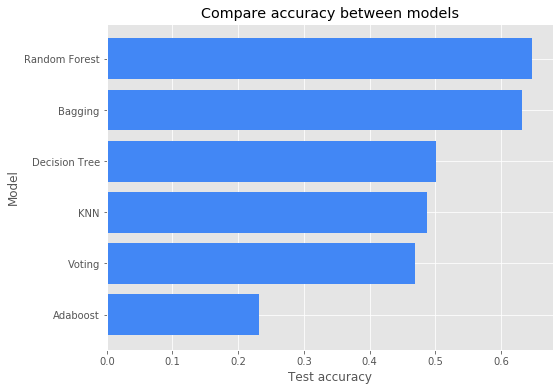

In [38]:
plt.figure(figsize=(8,6))
plt.style.use('ggplot')
plt.barh(sort_accuracy.index, sort_accuracy, color = '#4287f5')
plt.xlabel('Test accuracy')
plt.ylabel('Model')
plt.title('Compare accuracy between models')
plt.show()

#### <font color='blue'>OPTIMIZE HYPER PARAMETER ON RANDOM FOREST<font>

In [39]:
#get train set and validation set
train_split_id = list(range(1600, 1632)) #32 subjects
validation_id = list(range(1632, 1640)) #8 subjects

train_split_df = df.query('subject_id in @train_split_id') #data of 32 subjects
validation_df = df.query('subject_id in @validation_id') #data of 8 subjects

In [40]:
X_train_split = train_split_df.drop(['subject_id', 'activity_code','activity'], axis=1)
y_train_split = train_split_df['activity']

X_validation = validation_df.drop(['subject_id', 'activity_code','activity'], axis=1)
y_validation = validation_df['activity']

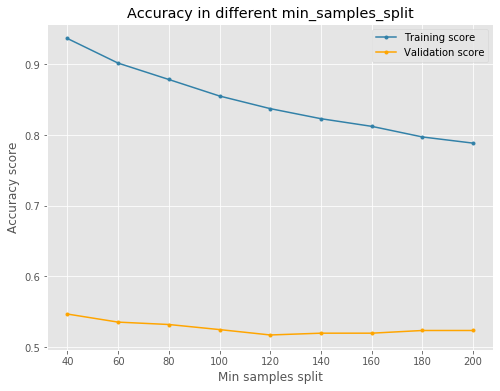

In [41]:
#optimize hyperparameter on min_samples_split
train_accuracy_list = list()
validation_accuracy_list = list()

sample_splits = range(40,201,20)

for n_split in sample_splits:
    forest_model = RandomForestClassifier(min_samples_split = n_split, random_state = 1)
    forest_model.fit(X_train_split, y_train_split)
    train_accuracy_list.append(forest_model.score(X_train_split, y_train_split))
    validation_accuracy_list.append(forest_model.score(X_validation, y_validation))   
#plot train_scores and validation_scores
plt.figure(figsize =(8,6))
plt.style.use('ggplot')
plt.plot(sample_splits, train_accuracy_list, label='Training score', marker='.', color = '#3281a8')
plt.plot(sample_splits, validation_accuracy_list, label='Validation score', marker='.', color='orange')
plt.xlabel('Min samples split')
plt.ylabel('Accuracy score')
plt.title('Accuracy in different min_samples_split')
plt.xticks(sample_splits)
plt.legend()
plt.show()

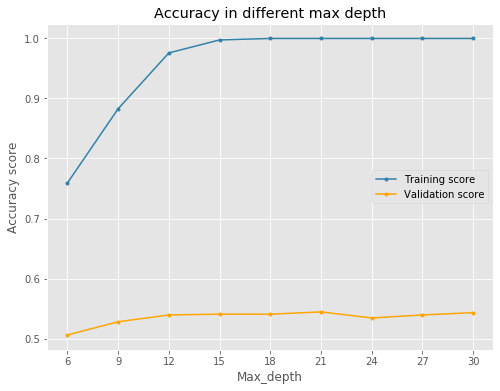

In [42]:
#optimize hyperparameter on max_depth
train_accuracy_list = list()
validation_accuracy_list = list()
list_max_depth = range(6,31,3)

for n_depth in list_max_depth:
    forest_model = RandomForestClassifier(max_depth = n_depth, random_state = 1)
    forest_model.fit(X_train_split, y_train_split)
    train_accuracy_list.append(forest_model.score(X_train_split, y_train_split))
    validation_accuracy_list.append(forest_model.score(X_validation, y_validation))   
#plot train_scores and validation_scores
plt.figure(figsize =(8,6))
plt.style.use('ggplot')
plt.plot(list_max_depth, train_accuracy_list, label='Training score', marker='.', color = '#3281a8')
plt.plot(list_max_depth, validation_accuracy_list, label='Validation score', marker='.', color='orange')
plt.xlabel('Max_depth')
plt.ylabel('Accuracy score')
plt.title('Accuracy in different max depth')
plt.xticks(list_max_depth)
plt.legend()
plt.show()

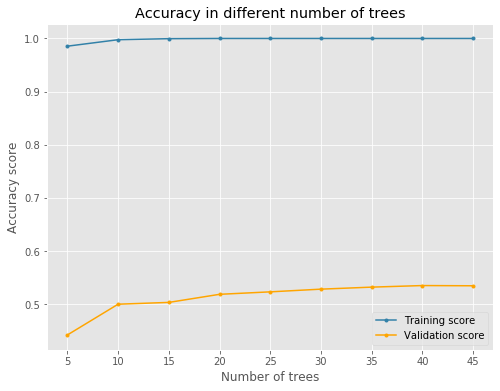

In [43]:
#optimize hyperparameter on n_estimators
train_accuracy_list = list()
validation_accuracy_list = list()
number_trees = list(range(5, 50, 5))


for n_trees in number_trees:
    forest_model = RandomForestClassifier(n_estimators = n_trees, random_state = 1)
    forest_model.fit(X_train_split, y_train_split)
    train_accuracy_list.append(forest_model.score(X_train_split, y_train_split))
    validation_accuracy_list.append(forest_model.score(X_validation, y_validation))   
#plot train_scores and validation_scores
plt.figure(figsize =(8,6))
plt.style.use('ggplot')
plt.plot(number_trees, train_accuracy_list, label='Training score', marker='.', color = '#3281a8')
plt.plot(number_trees, validation_accuracy_list, label='Validation score', marker='.', color='orange')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy score')
plt.title('Accuracy in different number of trees')
plt.xticks(number_trees)
plt.legend()
plt.show()

<font color='blue'>From 3 plots above, the best chosen hyperparameters are:  min_samples_split = 40, max_depth = 21, n_estimators = 40 </font>

In [44]:
forest_model = RandomForestClassifier(min_samples_split = 40, max_depth = 21, n_estimators = 40)
forest_model.fit(X_train, y_train)
train_accuracy = forest_model.score(X_train, y_train)
test_accuracy = forest_model.score(X_test, y_test)
print(f'Train accuracy: {train_accuracy} - Test accuracy: {test_accuracy}')

Train accuracy: 0.9253980891719745 - Test accuracy: 0.6506746626686657


<font color='blue'>The accuracy has been improved from 64.74% to 65.07% and the model is less overfitting (accuracy from training set reduced from 100% to 92.54%)</font>

#### Confusion Matrix

In [45]:
from sklearn.metrics import confusion_matrix

In [46]:
y_test_predict = forest_model.predict(X_test)
activity_names = ['Walking', 'Jogging', 'Stepping on stairs', 'Sitting', 'Standing', 'Typing', 'Brushing teeth', 'Eating soup', \
                'Eating chips', 'Eating pasta', 'Drinking from cup', 'Eating sandwich', 'Kicking (soccer ball)',\
                'Playing catch w tennis ball', 'Dribbling in basket ball', 'Writing', 'Clapping', 'Folding Clothes']

true_activities = ['true_'+ i for i in activity_names]
predict_activities = ['predict_'+ i for i in activity_names]

pd.DataFrame(data=confusion_matrix(y_test, y_test_predict), \
             index = true_activities, \
             columns = predict_activities)

,predict_Walking,predict_Jogging,predict_Stepping on stairs,predict_Sitting,predict_Standing,predict_Typing,predict_Brushing teeth,predict_Eating soup,predict_Eating chips,predict_Eating pasta,predict_Drinking from cup,predict_Eating sandwich,predict_Kicking (soccer ball),predict_Playing catch w tennis ball,predict_Dribbling in basket ball,predict_Writing,predict_Clapping,predict_Folding Clothes
true_Walking,96,1,35,0,0,0,0,0,0,0,0,0,62,1,0,0,0,0
true_Jogging,0,190,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
true_Stepping on stairs,5,2,133,0,0,0,0,0,0,0,0,0,21,1,0,0,0,0
true_Sitting,1,0,4,105,15,23,1,1,12,4,9,5,2,0,0,6,0,1
true_Standing,0,0,2,0,140,1,5,2,8,0,0,2,3,1,0,1,4,4
true_Typing,0,0,0,3,3,150,0,3,2,0,0,0,0,0,0,11,0,0
true_Brushing teeth,0,0,1,0,8,0,139,0,2,0,20,10,2,0,0,0,4,3
true_Eating soup,0,0,1,3,18,1,3,71,40,31,9,6,0,0,0,3,3,5
true_Eating chips,0,0,2,6,8,1,13,6,93,5,14,5,0,0,0,5,3,12
true_Eating pasta,0,0,1,2,13,18,4,27,33,70,1,7,0,0,0,10,2,1


### CONVOLUTIONAL NEURAL NETWORK

#### Training data set (id from 1600 to 1639 - total 40 subjects)

In [47]:
#get training data and reshape to put in Input layer
train_data = list()
train_target = list()
for device in ['phone', 'watch']:
    for sensor in ['accel','gyro']:        
        act_list = list()
        value_list = list()

        for subject_id in list(range(1600,1640)):
            df = create_df(f'raw/{device}/{sensor}/data_{subject_id}_{sensor}_{device}.txt')

            for key,act in enumerate(activities):
                x = df[df['activity_code'] == act]['x']
                y = df[df['activity_code'] == act]['y']
                z = df[df['activity_code'] == act]['z']
                
                #split data every time_steps and add condition if in order not to get the rest data which is less than time_steps
                x_new = [x[i:i+time_steps] for i in range(0, min_rows[subject_id][act], time_steps) if i+time_steps <= min_rows[subject_id][act]]
                y_new = [y[i:i+time_steps] for i in range(0, min_rows[subject_id][act], time_steps) if i+time_steps <= min_rows[subject_id][act]]
                z_new = [z[i:i+time_steps] for i in range(0, min_rows[subject_id][act], time_steps) if i+time_steps <= min_rows[subject_id][act]]

                x_np = np.array(x_new)
                y_np = np.array(y_new)
                z_np = np.array(z_new)

                x_reshape = x_np.reshape(x_np.shape[0],time_steps,1)
                y_reshape = y_np.reshape(y_np.shape[0],time_steps,1)
                z_reshape = z_np.reshape(z_np.shape[0],time_steps,1)

                values = np.zeros((int(np.floor(min_rows[subject_id][act]/time_steps)),time_steps,3))
            
                for j in range(x_np.shape[0]):
                    values[j] = np.column_stack((x_reshape[j], y_reshape[j], z_reshape[j]))
                    act_list.append(f'{act}')
                value_list.append(values)
        train_data.append(np.concatenate(value_list))
        act_df = pd.DataFrame({'target':act_list})
        train_target.append(np.array(pd.get_dummies(act_df)))

<mark>Understanding this is time series data and I shouldn't shuffle data but in this approach, it's till the feature approach so I should shuffle data as the model learns from every batch of input.</mark> 

In [48]:
# shuffle indicies
n_features = len(train_target[0])
indicies = np.arange(0,n_features)
np.random.shuffle(indicies)
indicies

array([ 7277,  5321,  8420, ..., 12468,   301,  3420])

In [49]:
shuffle_train_target = train_target[0][indicies]
train_phone_accel = train_data[0][indicies]
train_phone_gyro = train_data[1][indicies]
train_watch_accel = train_data[2][indicies]
train_watch_gyro = train_data[3][indicies]

In [50]:
print(shuffle_train_target.shape, train_phone_accel.shape)

(12560, 18) (12560, 200, 3)


#### Testing dataset (for subject id from 1640 to 1651 - total 11 subjects)

In [51]:
#get training data and reshape it
test_data = list()
test_target = list()
for device in ['phone', 'watch']:
    for sensor in ['accel','gyro']:        
        act_list = list()
        value_list = list()

        for subject_id in list(range(1640,1651)):
            df = create_df(f'raw/{device}/{sensor}/data_{subject_id}_{sensor}_{device}.txt')

            for key,act in enumerate(activities):
                x = df[df['activity_code'] == act]['x']
                y = df[df['activity_code'] == act]['y']
                z = df[df['activity_code'] == act]['z']

                x_new = [x[i:i+time_steps] for i in range(0, min_rows[subject_id][act], time_steps) if i+time_steps <= min_rows[subject_id][act]]
                y_new = [y[i:i+time_steps] for i in range(0, min_rows[subject_id][act], time_steps) if i+time_steps <= min_rows[subject_id][act]]
                z_new = [z[i:i+time_steps] for i in range(0, min_rows[subject_id][act], time_steps) if i+time_steps <= min_rows[subject_id][act]]

                x_np = np.array(x_new)
                y_np = np.array(y_new)
                z_np = np.array(z_new)

                x_reshape = x_np.reshape(x_np.shape[0],time_steps,1)
                y_reshape = y_np.reshape(y_np.shape[0],time_steps,1)
                z_reshape = z_np.reshape(z_np.shape[0],time_steps,1)

                values = np.zeros((int(np.floor(min_rows[subject_id][act]/time_steps)),time_steps,3))
            
                for j in range(x_np.shape[0]):
                    values[j] = np.column_stack((x_reshape[j], y_reshape[j], z_reshape[j]))
                    act_list.append(f'{act}')
                value_list.append(values)
        test_data.append(np.concatenate(value_list))
        act_df = pd.DataFrame({'target':act_list})
        test_target.append(np.array(pd.get_dummies(act_df)))

In [52]:
single_test_target = test_target[0]
test_phone_accel = test_data[0]
test_phone_gyro = test_data[1]
test_watch_accel = test_data[2]
test_watch_gyro = test_data[3]

#### Build model

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 3)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 200, 3)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 200, 3)       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 200, 3)       0                                            
____________________

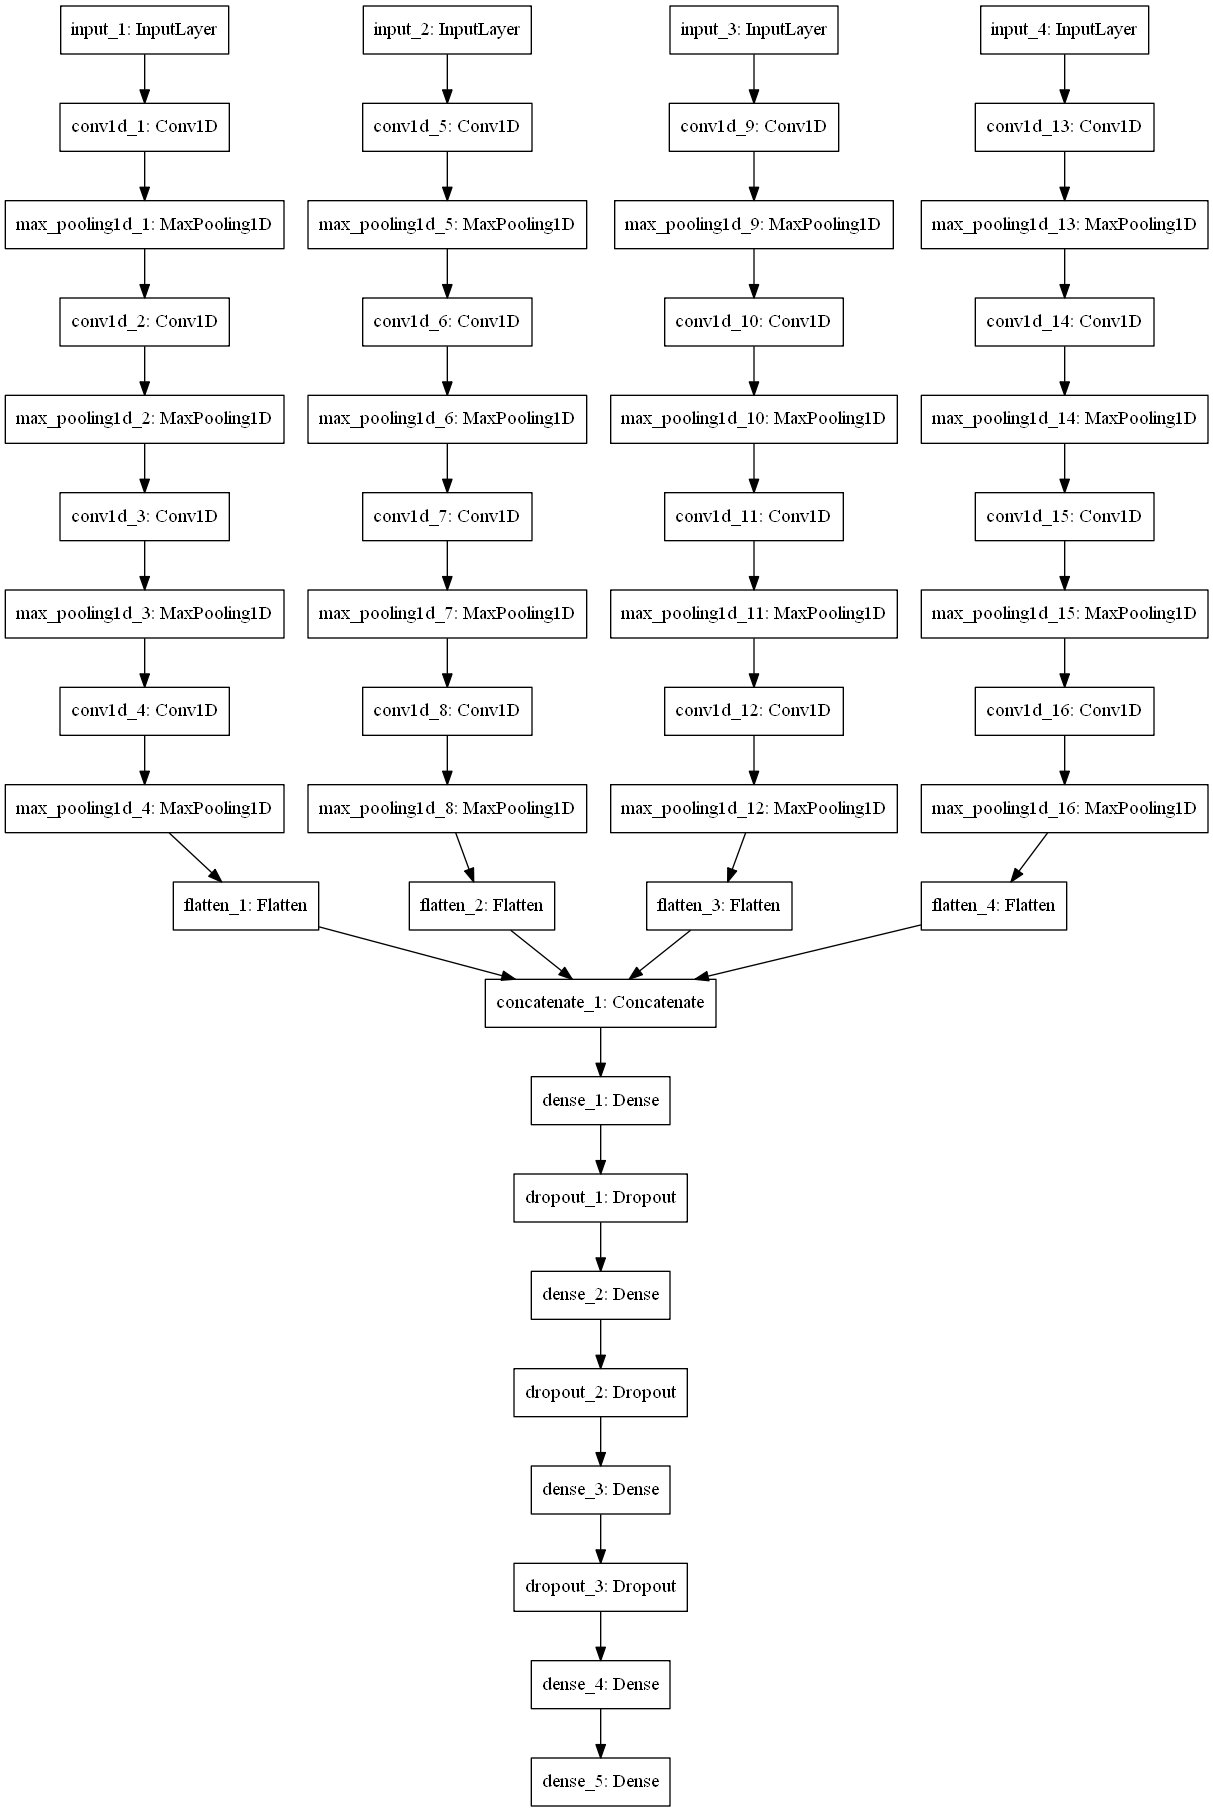

In [53]:
#first input model
input_tensor1 = Input(shape=(time_steps,3)) #data from 3 axis in every time_steps
conv11 = Conv1D(32, kernel_size=5,activation='relu', padding='same')(input_tensor1) #apply zero padding, size of output feature-maps will be the same as the input feature-maps 
pooling11 = MaxPooling1D(2)(conv11)
conv12 = Conv1D(32, kernel_size=5,activation='relu', padding='same')(pooling11)
pooling12 = MaxPooling1D(2)(conv12)
conv13 = Conv1D(16, kernel_size=5,activation='relu', padding='same')(pooling12)
pooling13 = MaxPooling1D(2)(conv13)
conv14 = Conv1D(16, kernel_size=5,activation='relu', padding='same')(pooling13)
pooling14 = MaxPooling1D(2)(conv14)
flat1 = Flatten()(pooling14)

#second input model
input_tensor2 = Input(shape=(time_steps,3))
conv21 = Conv1D(32, kernel_size=5, activation='relu', padding='same')(input_tensor2)
pooling21 = MaxPooling1D(2)(conv21)
conv22 = Conv1D(32, kernel_size=5,activation='relu', padding='same')(pooling21)
pooling22 = MaxPooling1D(2)(conv22)
conv23 = Conv1D(16, kernel_size=5,activation='relu', padding='same')(pooling22)
pooling23 = MaxPooling1D(2)(conv23)
conv24 = Conv1D(16, kernel_size=5,activation='relu', padding='same')(pooling23)
pooling24 = MaxPooling1D(2)(conv24)
flat2 = Flatten()(pooling24)

#third input model
input_tensor3 = Input(shape=(time_steps,3))
conv31 = Conv1D(32, kernel_size=5,activation='relu', padding='same')(input_tensor3) 
pooling31 = MaxPooling1D(2)(conv31)
conv32 = Conv1D(32, kernel_size=5,activation='relu', padding='same')(pooling31)
pooling32 = MaxPooling1D(2)(conv32)
conv33 = Conv1D(16, kernel_size=5,activation='relu', padding='same')(pooling32)
pooling33 = MaxPooling1D(2)(conv33)
conv34 = Conv1D(16, kernel_size=5,activation='relu', padding='same')(pooling33)
pooling34 = MaxPooling1D(2)(conv34)
flat3 = Flatten()(pooling34)

#fourth input model
input_tensor4 = Input(shape=(time_steps,3))
conv41 = Conv1D(32, kernel_size=5, activation='relu', padding='same')(input_tensor4)
pooling41 = MaxPooling1D(2)(conv41)
conv42 = Conv1D(32, kernel_size=5,activation='relu', padding='same')(pooling41)
pooling42 = MaxPooling1D(2)(conv42)
conv43 = Conv1D(16, kernel_size=5,activation='relu', padding='same')(pooling42)
pooling43 = MaxPooling1D(2)(conv43)
conv44 = Conv1D(16, kernel_size=5,activation='relu', padding='same')(pooling43)
pooling44 = MaxPooling1D(2)(conv44)
flat4 = Flatten()(pooling44)

#merge input models
merge = concatenate([flat1, flat2, flat3, flat4])

hidden1 = Dense(128, activation='relu')(merge)
dropout1 = Dropout(0.25)(hidden1)
hidden2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.25)(hidden2)
hidden3 = Dense(64, activation='relu')(dropout2)
dropout3 = Dropout(0.25)(hidden3)
hidden4 = Dense(32, activation='relu')(dropout3)
output = Dense(18, activation='softmax')(hidden4)
model = Model(inputs=[input_tensor1, input_tensor2, input_tensor3, input_tensor4], outputs=output)

#summarize layers
model.summary()

#plot graph
plot_model(model, to_file='layout.png')

In [54]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5) #halt the training of model if the val_loss does not decrease in next 5 epochs
model.fit([train_phone_accel, train_phone_gyro, train_watch_accel, train_watch_gyro], \
          shuffle_train_target, \
          validation_split=0.3, \
          epochs=50, batch_size=128,
          callbacks=[early_stopping]
         )

Instructions for updating:
Use tf.cast instead.
Train on 8792 samples, validate on 3768 samples
Epoch 1/50
8792/8792 [==============================] - 12s 1ms/step - loss: 2.4125 - accuracy: 0.1687 - val_loss: 1.8237 - val_accuracy: 0.3365
Epoch 2/50
8792/8792 [==============================] - 11s 1ms/step - loss: 1.7828 - accuracy: 0.3499 - val_loss: 1.3665 - val_accuracy: 0.5072
Epoch 3/50
8792/8792 [==============================] - 11s 1ms/step - loss: 1.4205 - accuracy: 0.4804 - val_loss: 1.1339 - val_accuracy: 0.5804
Epoch 4/50
8792/8792 [==============================] - 11s 1ms/step - loss: 1.2255 - accuracy: 0.5488 - val_loss: 1.0467 - val_accuracy: 0.6200
Epoch 5/50
8792/8792 [==============================] - 11s 1ms/step - loss: 1.0759 - accuracy: 0.6083 - val_loss: 0.8883 - val_accuracy: 0.6685
Epoch 6/50
8792/8792 [==============================] - 11s 1ms/step - loss: 0.9541 - accuracy: 0.6580 - val_loss: 0.8785 - val_accuracy: 0.6913
Epoch 7/50
8792/8792 [============

In [55]:
#accuracy on train set
train_score = model.evaluate([train_phone_accel, train_phone_gyro, train_watch_accel, train_watch_gyro], shuffle_train_target, batch_size=128)

# accuracy on test set
test_score = model.evaluate([test_phone_accel, test_phone_gyro, test_watch_accel, test_watch_gyro], single_test_target)

print('Training accuracy:', train_score[1], ' Test accuracy:', test_score[1])

3335/3335 [==============================] - 1s 396us/step
Training accuracy: 0.931369423866272  Test accuracy: 0.6677660942077637


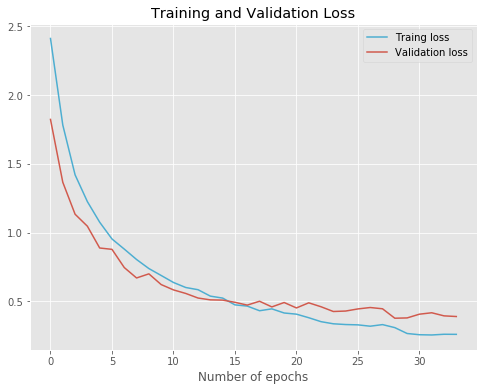

In [56]:
plt.style.use('ggplot')
plt.figure(figsize=(8,6))
plt.plot(model.history.history['loss'], color='#4daed1', label='Traing loss')
plt.plot(model.history.history['val_loss'], color='#d15a4d',label='Validation loss')
plt.xlabel('Number of epochs')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

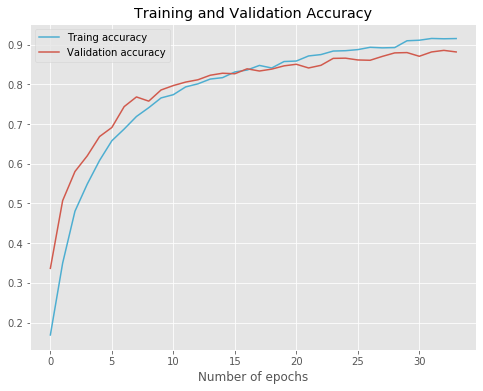

In [57]:
plt.style.use('ggplot')
plt.figure(figsize=(8,6))
plt.plot(model.history.history['accuracy'], color='#4daed1', label='Traing accuracy')
plt.plot(model.history.history['val_accuracy'], color='#d15a4d',label='Validation accuracy')
plt.xlabel('Number of epochs')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [58]:
predict_target = model.predict([test_phone_accel, test_phone_gyro, test_watch_accel, test_watch_gyro])
predict_target

array([[9.3946093e-01, 8.4384583e-13, 6.0538810e-02, ..., 1.1310921e-19,
        4.5937827e-18, 2.1407626e-17],
       [1.6103606e-01, 5.1248374e-08, 8.3832091e-01, ..., 1.3551729e-12,
        1.3962453e-12, 6.1729469e-11],
       [4.9938865e-02, 5.8355495e-06, 9.4899046e-01, ..., 1.7016289e-11,
        2.2760108e-11, 2.6595576e-10],
       ...,
       [1.6224841e-09, 1.2580602e-10, 9.6379287e-09, ..., 7.0308403e-07,
        4.9256708e-04, 9.9754637e-01],
       [3.9350756e-08, 3.2503237e-08, 2.1958473e-07, ..., 2.1434429e-05,
        2.9411807e-03, 9.9513865e-01],
       [2.8589501e-12, 1.1490077e-11, 1.2486957e-10, ..., 2.2989713e-08,
        1.6882173e-05, 9.9993682e-01]], dtype=float32)

In [59]:
y_test_predict = [np.argmax(i) for i in predict_target]
y_test = [np.argmax(i) for i in single_test_target]
    
activity_names = ['Walking', 'Jogging', 'Stepping on stairs', 'Sitting', 'Standing', 'Typing', 'Brushing teeth', 'Eating soup', \
                'Eating chips', 'Eating pasta', 'Drinking from cup', 'Eating sandwich', 'Kicking (soccer ball)',\
                'Playing catch w tennis ball', 'Dribbling in basket ball', 'Writing', 'Clapping', 'Folding Clothes']

true_activities = ['true_'+ i for i in activity_names]
predict_activities = ['predict_'+ i for i in activity_names]

#get confusion matrix
pd.DataFrame(data=confusion_matrix(y_test, y_test_predict), \
             index = true_activities, \
             columns = predict_activities)

,predict_Walking,predict_Jogging,predict_Stepping on stairs,predict_Sitting,predict_Standing,predict_Typing,predict_Brushing teeth,predict_Eating soup,predict_Eating chips,predict_Eating pasta,predict_Drinking from cup,predict_Eating sandwich,predict_Kicking (soccer ball),predict_Playing catch w tennis ball,predict_Dribbling in basket ball,predict_Writing,predict_Clapping,predict_Folding Clothes
true_Walking,105,0,73,0,0,0,0,0,0,0,0,0,15,1,1,0,0,0
true_Jogging,0,188,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
true_Stepping on stairs,4,0,149,0,0,0,0,0,0,0,0,0,8,0,0,0,0,1
true_Sitting,0,0,0,111,0,39,0,4,6,3,16,0,1,0,0,9,0,0
true_Standing,0,0,0,5,120,4,3,4,10,1,6,9,6,1,0,1,0,3
true_Typing,0,0,0,6,0,148,0,0,1,12,0,0,0,0,0,5,0,0
true_Brushing teeth,0,0,0,1,0,0,172,0,0,0,0,1,0,0,0,0,15,0
true_Eating soup,0,0,0,1,0,0,0,95,13,64,9,11,0,0,0,0,0,1
true_Eating chips,0,0,0,13,14,2,0,16,67,23,10,19,0,2,0,0,0,7
true_Eating pasta,0,0,0,2,1,21,0,28,9,87,3,10,0,0,0,9,1,18


<font color='blue'>From both confusion matrixes from random forest and convolutional neural network, the models didn’t perform well in eating activities and it’s confused between stepping on stairs with walking, sitting with eating activities…</font>

<mark>Both approaches in this project are feature approaches. For a complete time series approach, I plan to use LSTM or HMM models, which receive entire series as inputs, rather than window values. That is my future work to make a better model.</mark>